# Project plate detection

in this project, we are:

- download the necessary dataset for training the neural network   
- create a class that processes the data for training the model  
- define the architecture of the model   
- write a function for training + consider variants of accelerating model training   
- train and save the model   
- visualize the results of our trained model  

### 1) Data download

>For this type of neural network, you need a lot of data for training, so I used a dataset with almost 30K car photos and license plate layout files.

In [ ]:
path = 'dataset' #i used relative path (so there could theoretically be a problem, If you have problems with the dataset path, try changing it yourself)

In [ ]:
# import kagglehub
# path = kagglehub.dataset_download("fareselmenshawii/large-license-plate-dataset")
# print("Path to dataset files:", path)

### 2) Necessary imports

mostly here is pythorch for the main code (I'll explain in the code what each part is for), matplotlib for the data output 

In [ ]:
from torchvision.transforms import v2
from PIL import Image
import torch.utils.data as data
import torch
import os # To work with files and paths
import torch.nn as nn 
import torch.optim as optim
import tqdm # to track model training progress
import random # for random values
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.amp import autocast, GradScaler

### 3) Data preparation

In [ ]:
def DataFromTxt(path): # to get data from txt
    f = open(path, "r")
    dots = list(map(float,f.read().split()))
    if len(dots[1:5]) == 0:
        dots =[0,0,0,0,0,0]
    return dots[1:5]

use dataset class for data conversion and preparation 

In [ ]:
class CarPlatesDataset(data.Dataset):
    def __init__(self,path,type="train"):#type of imges
        self.path = path
        self.type = type
        self.lenght = len(os.listdir(os.path.join(self.path,'labels',type)))


    def __getitem__(self, index):
        name = os.listdir(os.path.join(self.path,'labels',self.type ))[index][:-4]
        datasetimgpath = os.path.join(self.path,'images',self.type ,name+'.jpg')
        datasetdotpath = os.path.join(self.path,'labels',self.type ,name+'.txt')
        resize =  v2.Resize(size=(128,128))
        toimg = v2.ToImage()
        img=Image.open(datasetimgpath)
        img = img.convert("RGB")
        img =resize(toimg(img)).float()/255.0
        return img, torch.Tensor(DataFromTxt(datasetdotpath))
    
    def __len__(self):
        return self.lenght

> In this class, there are three required functions: the initialization function, a function for displaying the data, and a function for showing the number of instances.

We create our class CarPlatesDataset and immediately generate ready-to-use training data based on it using the imported DataLoader class.(same with validation dataset)

In [ ]:
d_train = CarPlatesDataset(path,type='train')
train_data = data.DataLoader(d_train,batch_size=64,shuffle=True)

In [ ]:
d_val = CarPlatesDataset(path,type='val')
val_data = data.DataLoader(d_val,batch_size=64,shuffle=True)

 ### 4) Create the architecture of the model 

Here we also write our own class based on the imported Module class, here the __init__ and forward classes are mandatory. 

>I have chosen a basic architecture similar to the architecture of the vgg family of networks, but you can choose and test any architecture you want, just use the Sequential class and create your own architecture in it using classes from the torch.nn library as building blocks.

In [ ]:
class CNNCarPlates(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,32,(3,3),1,padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,(3,3),1,padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(32,64,(3,3),1,padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,(3,3),1,padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,(3,3),1,padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128,256,(3,3),1,padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,(3,3),1,padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.25),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=4),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = CNNCarPlates(128*128*3,4) #and immediately create our model 

>also at this point it is worth choosing an optimizer and loss function, for our model the following will be suitable MSELoss and Adam

In [ ]:
optimizer = optim.Adam(params=model.parameters(),lr=0.001)
loss_func = nn.MSELoss()

### 4.5) Optimize and accelerate model training  

>First of all, of course, if you have a gpu, it is better to put training models on it

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f'Model on device: {device}')

Model on device: cuda


>and also enable automatic optimization from the cuDNN library

In [18]:
torch.backends.cudnn.benchmark = True

>GradScaler inside the learning cycle is needed to save memory on the gpu and as a consequence accelerate learning

> Also for optimizations, I recommend that you:
reduce the number of fully connected layers in the model and/or
reduce the size of the input images
>>I don't have a server or even a desktop computer, I trained the model on a laptop and to keep using it for training I trained the model in sections, so after each training I saved the model and the optimizer and continued training from a checkpoint, it helped me a lot. 

### 5) Model training!

With the exception of GradScaler and tqdm it is a standard training cycle 
> +cycle to test on validation data to determine network quality, stop training and prevent overtraining 

In [ ]:
def traininepochs(epochs):
    for _e in range(epochs):
        loss_mean = 0
        lm_count = 0

        scaler = GradScaler(device) # is the GradScaler I was talking about in 4.5

        train_tqdm = tqdm.tqdm(train_data, leave=True)
        for x_train, y_train in train_tqdm:
            x_train, y_train = x_train.to(device), y_train.to(device)
            model.train()

            optimizer.zero_grad()

            with autocast(device):
                predict = model(x_train)
                loss = loss_func(predict, y_train)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            lm_count += 1
            loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
            train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.6f}")

        model.eval()
        Q_val = 0
        count_val = 0

        for x_val, y_val in val_data:
            x_val, y_val = x_val.to(device), y_val.to(device)
            with torch.no_grad():
                p = model(x_val)
                loss = loss_func(p, y_val)
                Q_val += loss.item()
                count_val += 1

        Q_val /= count_val

        print(f" | loss_mean={loss_mean:.6f}, Q_val={Q_val:.6f}")

For me the training was conducted in the following form: loading a checkpoint, training with functions, saving a checkpoint, analyzing data

In [21]:
checkpoint = torch.load('checkpoint36.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [45]:
traininepochs(1)

Epoch [1/1], loss_mean=0.001217: 100%|██████████| 398/398 [22:22<00:00,  3.37s/it]


 | loss_mean=0.001217, Q_val=0.015491


this line of code at the bottom loads the saved model and optimizer values

In [47]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'checkpoint36.pth')

>This is my last recorded data, the number is not the number of epochs, since I used to train 2-3 at a time, so the number + 5-7 is the number of epochs.

num of model - validation loss  
33 - 17  
35 - 16  
36 - 1549  

>>I will also save the checkpoint for you so you can continue training the model instead of starting from scratch.

the file is too big so the link: [OwO](https://drive.google.com/file/d/1kdICDkuCsBGTdZv8gyh2J9aJIdZGol28/view?usp=sharing)

### 6) Use and evaluation of the model 

##### !first make sure you put the model in evaluation mode.!

In [23]:
model.eval()

CNNCarPlates(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

create a familiar dataset but with test data 

In [45]:
d_test = CarPlatesDataset(path,type='test')

write functions to show the data

In [61]:
def predictPredictNotResz(index, data='test'):
    if data == 'train':
        dataset = d_train
    elif data == 'val':
        dataset = d_val
    elif data == 'test':
        dataset = d_test
    else:
        return "incorect dataset try data = test, val or train"
    p = model.forward(torch.unsqueeze(dataset[index][0],0).to(device))
    name = os.path.join(path,'images',data ,os.listdir(os.path.join(path,'images', data ))[index])
    img=Image.open(name)
    img = img.convert("RGB")

    image_tensor = torch.tensor(plt.imread(name))  
    H, W = image_tensor.shape[:2]

    x, y, w, h = torch.Tensor.tolist(torch.squeeze(p))

    x_tl = x*W - w*W / 2
    y_tl = y*H - h*H / 2


    _, ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((x_tl, y_tl), w*W, h*H, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.axis("off")
    plt.show()

In [62]:
def showResults(n,data='test'):
    datalen = len(os.listdir(os.path.join(path,'labels','test')))
    for i in [random.randint(0, datalen) for _ in range(n)]:
        predictPredictNotResz(i, data=data)

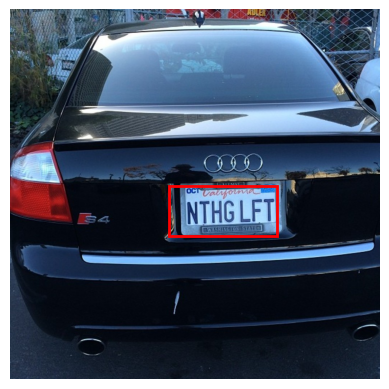

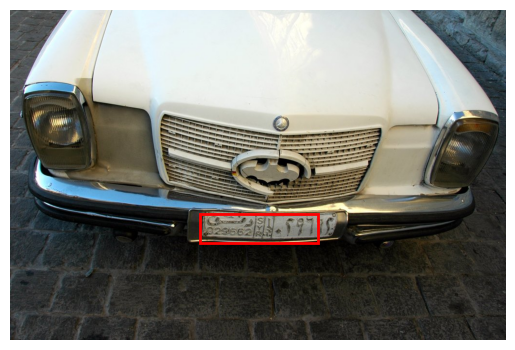

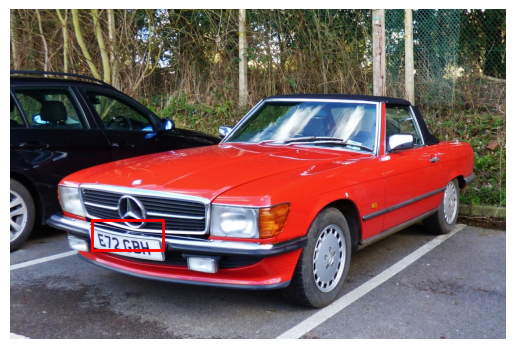

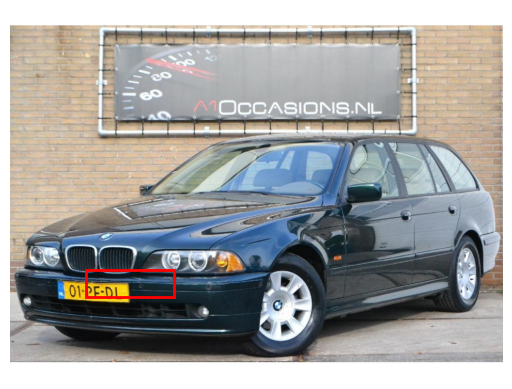

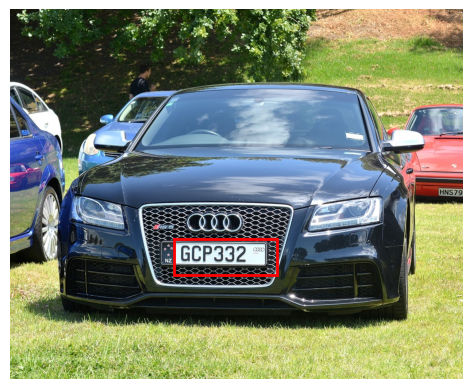

In [72]:
showResults(5)

##  That's fine !

I'm so glad the model identifies license plates on cars.
Although the accuracy is not perfect, I am happy with the result because before me people who worked with this dataset only used YOLO to identify license plates and not their own trained neural network.
What will happen with this project: 
1) I will upload it to my github and linkadin 
2) I will rewrite the model so that as output data it will be possible to detect several license plates on one photo
3) I will continue training to achieve higher accuracy 
4) I will try to make a microservice based on this model and upload it to the server using such tools as fastAPI and Docker. 


<small>_I would like to express my gratitude to the creator of the dataset, Fares Elmenshawii, for the high-quality data, as well as to the YouTube channel Selfedu for the PyTorch course, which helped me refresh my memory and made the transition from TensorFlow to PyTorch much easier. I also want to thank David Foster, whose writing style keeps me engaged and never lets me get bored or disappointed in this field._</small>

## thank you for your attention!

In [ ]:
showResults(20)